In [1]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler, UNet2DModel

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Hyperparameters & device

BATCH_SIZE = 128
NUM_EPOCHS = 10
T = 100 # Timesteps
IMG_SIZE = 32
LR = 1e-3 # Learning rate
UNET_EXP = 6 # Exponent of unet (8 -> 16, ...)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


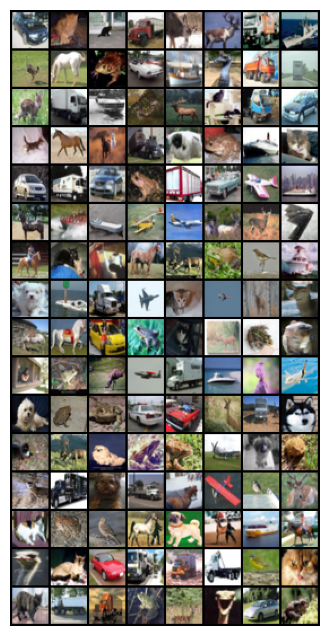

In [ ]:
#@title MNIST Dataset

dataset = torchvision.datasets.CIFAR10(root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

x, y = next(iter(train_dataloader))

# Create a grid of images
grid = torchvision.utils.make_grid(x)
# Convert the grid to a numpy image
npimg = grid.permute(1, 2, 0).cpu().numpy()

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis('off')
plt.show()


In [4]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

# Model

In [5]:
#@title Create model with input, output channels

# Create the network
net = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=4,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=LR) 

# Keeping a record of the losses for later viewing
losses = []

sched = DDPMScheduler(T, prediction_type="sample")

num_of_params = sum([p.numel() for p in net.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# The training loop
for epoch in range(NUM_EPOCHS):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')


Number of trainable parameters in the model: 2,795,971
Finished epoch 0. Average loss for this epoch: 0.027208
Finished epoch 1. Average loss for this epoch: 0.017571
Finished epoch 2. Average loss for this epoch: 0.015906
Finished epoch 3. Average loss for this epoch: 0.014472
Finished epoch 4. Average loss for this epoch: 0.013681
Finished epoch 5. Average loss for this epoch: 0.013309
Finished epoch 6. Average loss for this epoch: 0.012936
Finished epoch 7. Average loss for this epoch: 0.013186
Finished epoch 8. Average loss for this epoch: 0.012748
Finished epoch 9. Average loss for this epoch: 0.012163


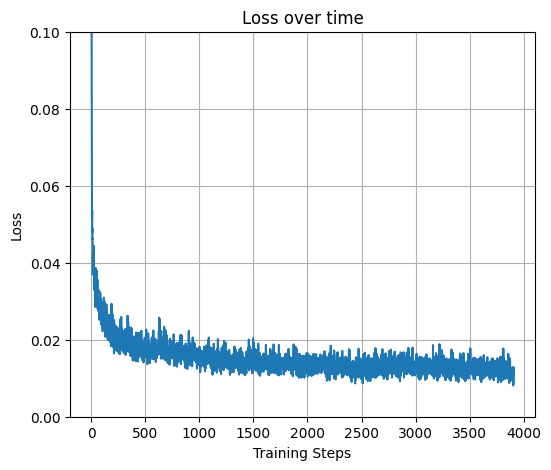

In [6]:
plt.figure(figsize=(6, 5))
plt.plot(losses)
plt.ylim(0, 0.1)
plt.title('Loss over time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

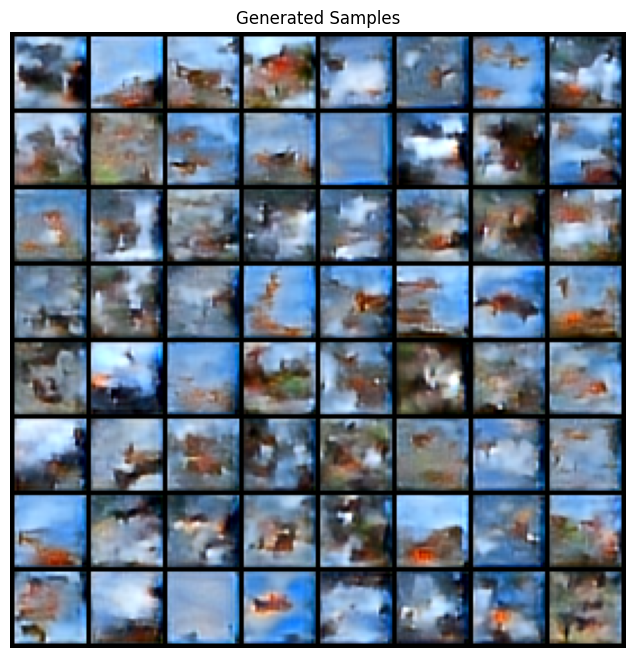

In [7]:
# Generate samples
n_steps = 40
x = torch.rand(64, 3, 32, 32).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i) if (n_steps-i) != 0 else 1
  x = x*(1-mix_factor) + pred*mix_factor

# Detach from the computation graph and move to CPU for plotting
x = x.detach().cpu()

# Create a grid of images
# We use permute to change the tensor shape from (C, H, W) to (H, W, C) for displaying
grid = torchvision.utils.make_grid(x, nrow=8).clip(0, 1)
grid = rearrange(grid, "c h w -> h w c")

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.title('Generated Samples')
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

In [8]:
#@title Save the model

path = "trained_model_cifar10_working_samples.pt"
torch.save(net, path)

In [16]:
#@title Load model

path = "trained_model_cifar10_working_samples.pt"
model = torch.load(path, weights_only=False)
model.to(device)
model.eval()
print("OK")

OK


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4574547..2.9796538].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5298703..3.0365062].


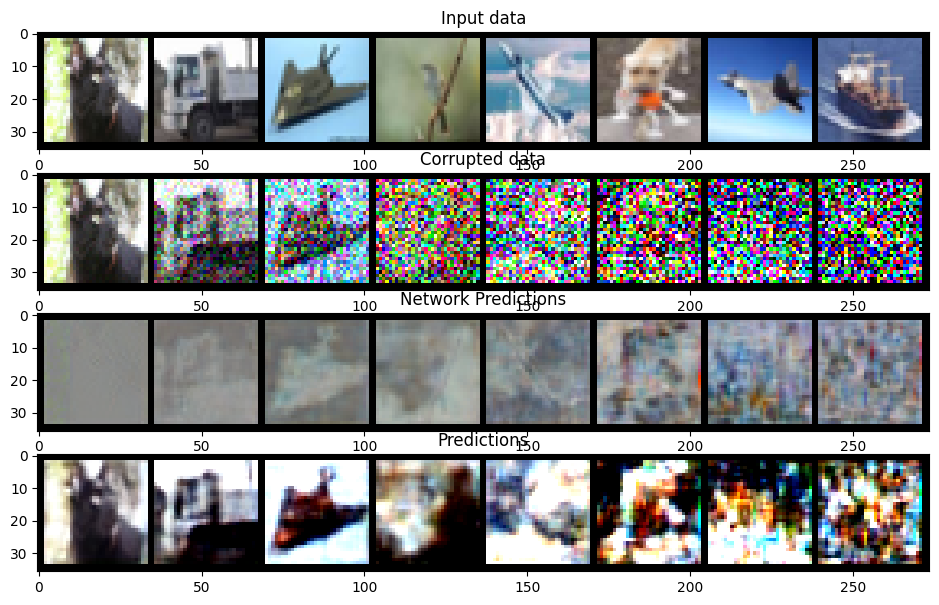

In [21]:
#@title Sampling

# Fetch some data
test_dataset = torchvision.datasets.CIFAR10(root="cifar10/", train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

x, y = next(iter(train_dataloader))
batch_size = 8
x = x[:batch_size] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
t = torch.linspace(0, T-1, batch_size).long().to(device)
noise = torch.randn_like(x).to(device)
x = x.to(device)
noisy_x = sched.add_noise(x, noise, t).to(device)

# Get the model predictions
with torch.no_grad():
    preds = model(noisy_x, t).sample.detach().cpu()
    x = x.detach().cpu()
    minus = x - preds

# Plot
fig, axs = plt.subplots(4, 1, figsize=(12, 7))
axs[0].set_title('Input data')
grid = torchvision.utils.make_grid(x) # Create a grid of images
npimg = grid.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[0].imshow(npimg)

axs[1].set_title('Corrupted data')
grid2 = torchvision.utils.make_grid(noisy_x) # Create a grid of images
npimg2 = grid2.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[1].imshow(npimg2)



minus = (minus - minus.min()) / (minus.max() - minus.min()) # Normalize to [0, 1]

axs[2].set_title('Network Predictions')
grid3 = torchvision.utils.make_grid(minus) # Create a grid of images
npimg3 = grid3.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[2].imshow(npimg3)

axs[3].set_title("Predictions")
grid4 = torchvision.utils.make_grid(preds)
npimg4 = grid4.permute(1, 2, 0).cpu().numpy() # Convert the grid to a numpy image
axs[3].imshow(npimg4)